In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import kagglehub
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
path = kagglehub.dataset_download("mohithsairamreddy/salary-data", path = "Salary_data.csv")

In [3]:
df = pd.read_csv(path)
df.head()

Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary  
0   90000.0  
1   65000.0  
2  150000.0  
3   60000.0  
4  200000.0

In [4]:
df.columns[df.isna().any()].tolist()


['Age',
 'Gender',
 'Education Level',
 'Job Title',
 'Years of Experience',
 'Salary']

In [5]:
# Fill nan values

df.fillna({
    'Age': df['Age'].median(),
    'Years of Experience': df['Years of Experience'].median(),
    'Salary': df['Salary'].median(),
}, inplace=True)

df.dropna(inplace = True)

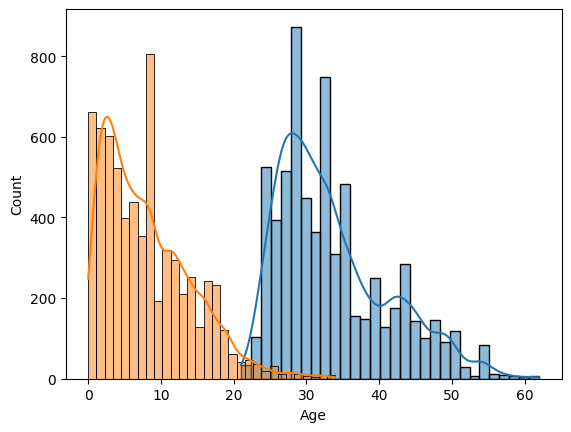

In [6]:
# Hist to visualize destribution of Age and Exp

sns.histplot(df['Age'], bins = 30, kde = True)
sns.histplot(df['Years of Experience'], bins = 30, kde = True)

plt.show()

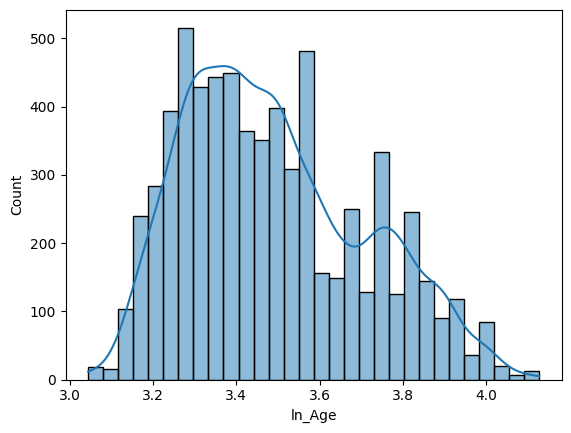

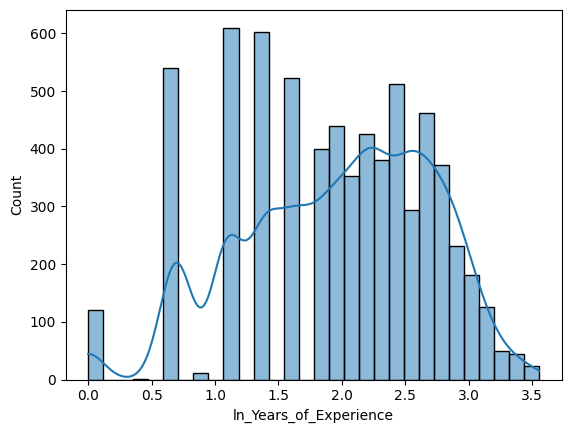

In [7]:
# Applying log normal to see if it can be normalized to normal destribution

df['ln_Age'] = np.log(df['Age'])
df['ln_Years_of_Experience'] = np.log1p(df['Years of Experience'])

sns.histplot(df['ln_Age'], bins = 30, kde = True)
plt.show()

sns.histplot(df['ln_Years_of_Experience'], bins = 30, kde = True)
plt.show()

# These look more normal than the previous chart, and outliers can be easily removed from here

In [8]:
# Remove outliers from Age and YOE

Q1_age = df['ln_Age'].quantile(0.25)
Q3_age = df['ln_Age'].quantile(0.75)
IQR_age = Q3_age - Q1_age

low_age = Q1_age - 1.5 * IQR_age
up_age = Q3_age + 1.5 * IQR_age

Q1_yoe = df['ln_Years_of_Experience'].quantile(0.25)
Q3_yoe = df['ln_Years_of_Experience'].quantile(0.75)
IQR_yoe = Q3_yoe - Q1_yoe

low_yoe = Q1_yoe - 1.5 * IQR_yoe
up_yoe = Q3_yoe + 1.5 * IQR_yoe

In [10]:
# Filter out outliers and return back to original scale
cleaned_df = df[(df['ln_Age'] >= low_age) & (df['ln_Age'] <= up_age)]
cleaned_df = df[(df['ln_Years_of_Experience'] >= low_yoe) & (df['ln_Years_of_Experience'] <= up_yoe)]

cleaned_df.head()

Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary    ln_Age  ln_Years_of_Experience  
0   90000.0  3.465736                1.791759  
1   65000.0  3.332205                1.386294  
2  150000.0  3.806662                2.772589  
3   60000.0  3.583519                2.079442  
4  200000.0  3.951244                3.044522

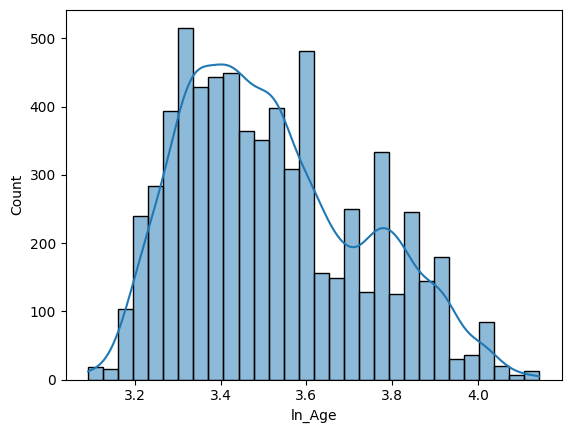

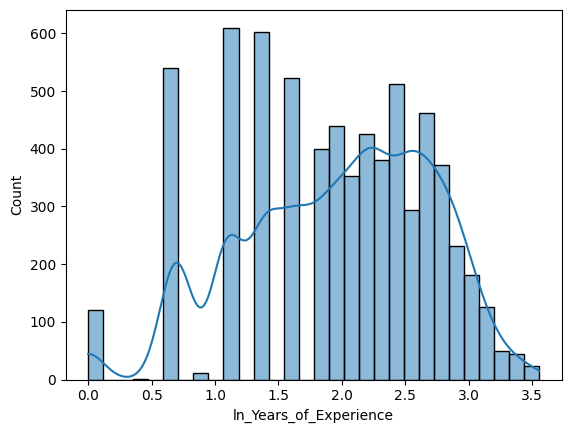

In [11]:
# Visualise the updated anf cleaned data

df['ln_Age'] = np.log1p(df['Age'])
df['ln_Years_of_Experience'] = np.log1p(df['Years of Experience'])

sns.histplot(df['ln_Age'], bins = 30, kde = True)
plt.show()

sns.histplot(df['ln_Years_of_Experience'], bins = 30, kde = True)
plt.show()

In [12]:
# Mean & median before & after removing outliers

mean_before = cleaned_df['Salary'].mean()
median_before = cleaned_df['Salary'].median()

print(f'Mean before: ${mean_before}')
print(f'Median before: ${median_before}')

Mean before: $115329.10565587226
Median before: $115000.0


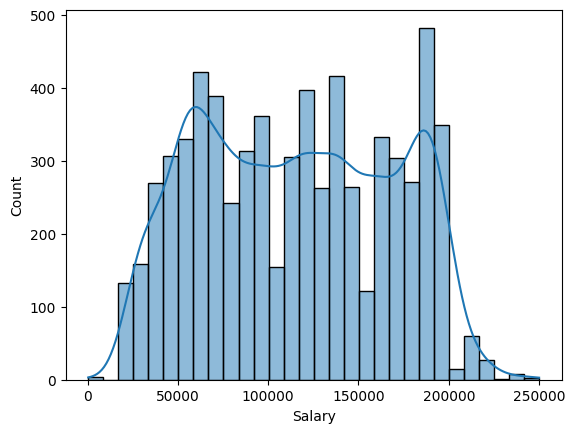

In [13]:
sns.histplot(cleaned_df['Salary'], bins=30, kde=True)
plt.show()

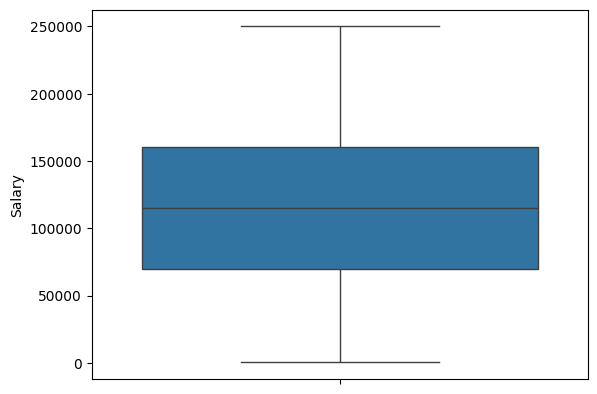

In [14]:
sns.boxplot(cleaned_df['Salary'])
plt.show()

In [15]:
# It looks like data is already well balanced, so no need to remove any outliers
# But even if we did, there wont be any much effect on results as we can visualize below

Q1_salary = cleaned_df['Salary'].quantile(0.25)
Q3_salary = cleaned_df['Salary'].quantile(0.75)
IQR_salary = Q3_salary - Q1_salary

low_salary = Q1_salary - 1.5 * IQR_salary
up_salary = Q3_salary + 1.5 * IQR_salary

cleaned_df = df[(df['Salary'] >= low_salary) & (df['Salary'] <= up_salary)]
cleaned_df.head()

Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary    ln_Age  ln_Years_of_Experience  
0   90000.0  3.496508                1.791759  
1   65000.0  3.367296                1.386294  
2  150000.0  3.828641                2.772589  
3   60000.0  3.610918                2.079442  
4  200000.0  3.970292                3.044522

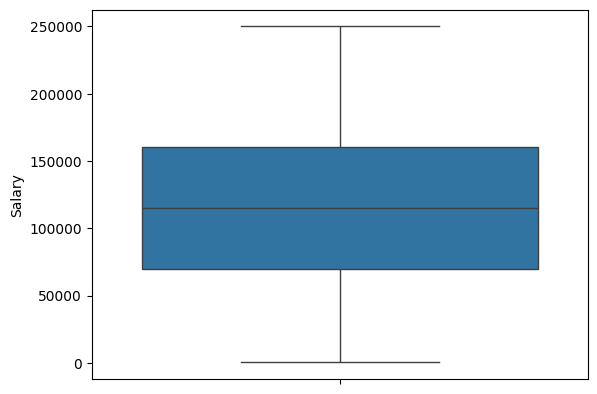

In [16]:
sns.boxplot(cleaned_df['Salary'])
plt.show()

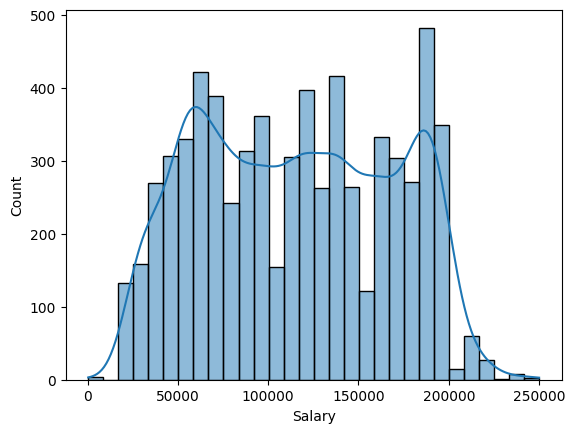

In [17]:
sns.histplot(cleaned_df['Salary'], bins=30, kde=True)
plt.show()

## Compare average salaries across different job roles using one-way ANOVA (Employee Salaries dataset).

In [26]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols("Salary ~ C(Q('Job Title'))", data = cleaned_df).fit()
table = sm.stats.anova_lm(model, typ=2)
table

# As the p value is 0, we can say that yes salary across diffr. job roles is really diferrent
# Now lets see which role contribites to it the most using turkey_hs

sum_sq      df          F  PR(>F)
C(Q('Job Title'))  1.239438e+13   191.0  67.381071     0.0
Residual           6.268562e+12  6509.0        NaN     NaN

In [27]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

result = pairwise_tukeyhsd(alpha=0.05, endog=cleaned_df['Salary'], groups=cleaned_df['Job Title'])
result.summary()

/Users/anirudhsingh/stats-foundational-data-analysis/.venv/lib/python3.13/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


<class 'statsmodels.iolib.table.SimpleTable'>